# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The business problem I am facing relates to predicting the salaries of a set of new job postings. I aim to train a machine learning model on data related to existing job postings and their salaries, and generalise that to accurately predict salaries for new postings.

In [1]:
#import your libraries
import pandas as pd
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns


#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"


__author__ = "Taimur Shabbir"
__email__ = "alitaimurshabbir@hotmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe

data_features = pd.read_csv('/Users/alitaimurshabbir/Desktop/salary-prediction/data/train_features.csv')
data_outcomes = pd.read_csv('/Users/alitaimurshabbir/Desktop/salary-prediction/data/train_salaries.csv')
data_combined = pd.merge(data_features, data_outcomes, on = 'jobId')

In [3]:
# checking whether 'merge' was executed successfully by examining number of rows

print(len(data_features))
print(len(data_outcomes))
print(len(data_combined))

1000000
1000000
1000000


### ---- 3 Clean the data ----

In [4]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

# As a first step, I will find what data is missing. We see that no data is missing

data_combined.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [5]:
# checking for potentially incorrect data among numerical variables

data_combined.describe()

data_combined[data_combined['salary'] == 0]

# There are records for salaries with a value of 0. These must be incorrect

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


The best way to deal with this missing data is to drop the relevant rows, for two reasons.

- First, the missing component is the outcome variable, salary, so we cannot use the traditional methods of data replacement we would use with missing values of features


- Second, we have 1 million rows in our table. Dropping 5 rows is going to be a trivial loss of data.

In [6]:
data_combined = data_combined.drop(data_combined[data_combined.salary == 0].index)

Next I want to check the unique values for a few columns with the 'object' data type. This is to see, for example, if there are misspellings for entries in the 'jobType' column.

In [7]:
data_combined['jobType'].value_counts()

SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64

In [8]:
data_combined['degree'].value_counts()

HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64

In [9]:
data_combined['major'].value_counts()

NONE           532353
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58594
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57800
Name: major, dtype: int64

There are no misspellings for the values in any of the columns investigated.

In [10]:
len(data_combined)


999995

### ---- 4 Explore the data (EDA) ----

In [11]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

**Investigate 'salary' distribution:**

Text(0,0.5,'Frequency')

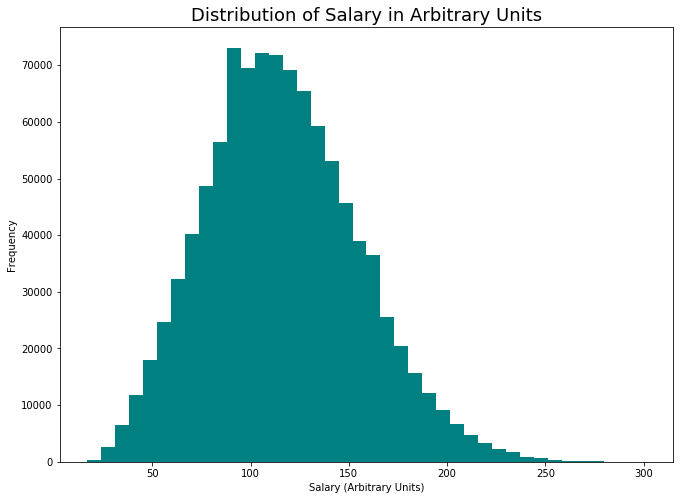

In [12]:
plt.figure(figsize = (11,8))

plt.hist(data_combined['salary'], bins = 40, color = 'teal')

plt.title('Distribution of Salary in Arbitrary Units', fontsize = 18)
plt.xlabel('Salary (Arbitrary Units)')
plt.ylabel('Frequency')


**Investigate numerical variables 'yearsExperience' and 'milesFromMetropolis':**

Text(0,0.5,'Miles')

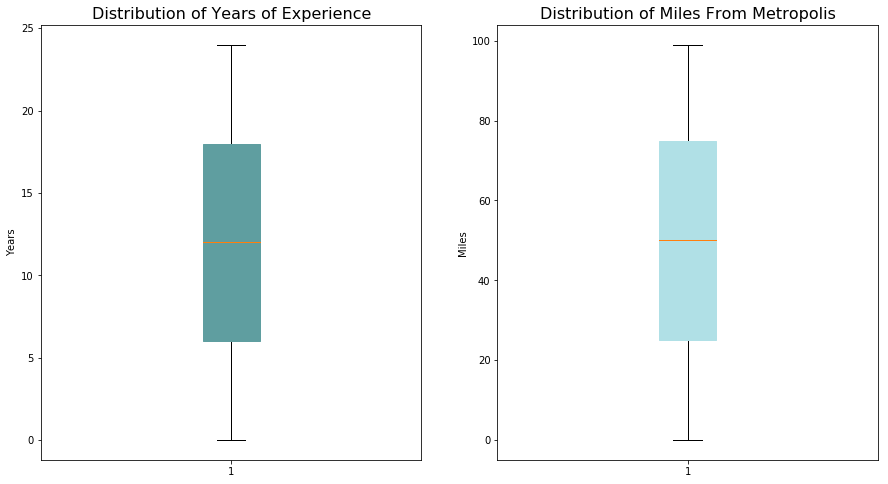

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

ax1.boxplot(data_combined['yearsExperience'],
            showfliers = True, patch_artist = True,
            boxprops = dict(facecolor = 'cadetblue', color = 'cadetblue'))
            
ax1.set_title('Distribution of Years of Experience', fontsize = 16)
ax1.set_ylabel('Years')



ax2.boxplot(data_combined['milesFromMetropolis'],
            showfliers = True, patch_artist = True, 
            boxprops = dict(facecolor = 'powderblue', color = 'powderblue'))
            
ax2.set_title('Distribution of Miles From Metropolis', fontsize = 16)
ax2.set_ylabel('Miles')

#### Scatter graphs with small samples of data

Text(0,0.5,'Salary (Arbitrary Units)')

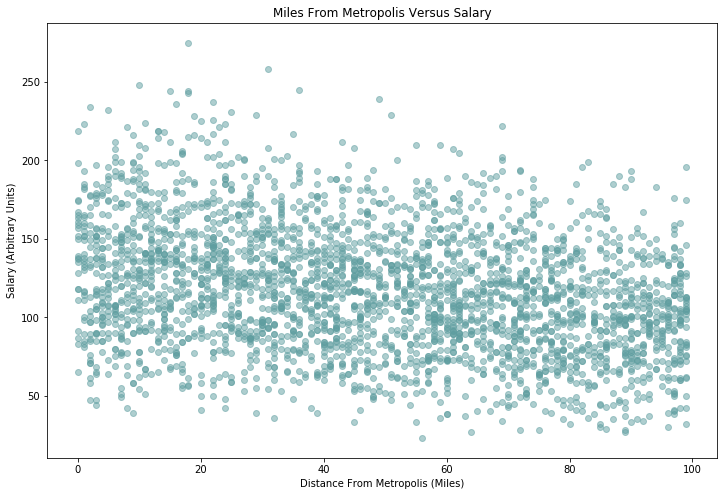

In [96]:
small_sample_data = data_combined.sample(n = 3000)

plt.figure(figsize = (12, 8))

plt.scatter(small_sample_data['milesFromMetropolis'],
            small_sample_data['salary'], alpha = 0.5,
            c = 'cadetblue')

plt.title('Miles From Metropolis Versus Salary')
plt.xlabel('Distance From Metropolis (Miles)')
plt.ylabel('Salary (Arbitrary Units)')

Text(0,0.5,'Salary (Arbitrary Units)')

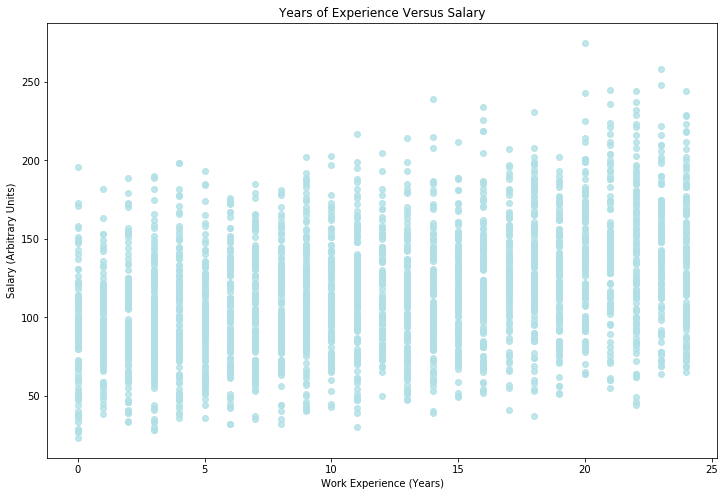

In [98]:
plt.figure(figsize = (12, 8))

plt.scatter(small_sample_data['yearsExperience'],
            small_sample_data['salary'], alpha = 0.8,
            c = 'powderblue')

plt.title('Years of Experience Versus Salary')
plt.xlabel('Work Experience (Years)')
plt.ylabel('Salary (Arbitrary Units)')

**Interpretation:**

- 'Salary' is fairly normally distributed with a slight positive skew, which means the mean and the median are greater than the mode. The mean is being 'pulled' up by a few instances with very large values (above 250)


- The median of years of work experience required is 12. 50% of the postings require between approximately 6 and 17 years. There are cases where the job posting is aimed at those who are starting their careers, with 0 years of experience, and cases where postings require candidates who have been in the workforce for a long time, approaching 24 years


- On the other hand, there are a few jobs available in Metropolis (0 miles away from this city) and a few who require a long commute (nearly 100 miles). These are extreme points, as the majority of postings lie between 25 and 75 miles


- Since these are our two main interval features, we can question whether we need to scale them. From the y-axes of both boxplots, there is a noticeable difference in the magnitude of the data. We keep in mind this observation for now and will return to it if needed


----

Next I want to see the distributions of salary among different types industries. 

I will choose 3 values for this variable just to get an idea of the data:

'AUTO', 'OIL' and 'EDUCATION'

In [14]:
# create dataframes

auto_salary_df = data_combined.loc[(data_combined['industry'] == 'AUTO')]

oil_salary_df = data_combined.loc[(data_combined['industry'] == 'OIL')]

education_salary_df = data_combined.loc[(data_combined['industry'] == 'EDUCATION')]

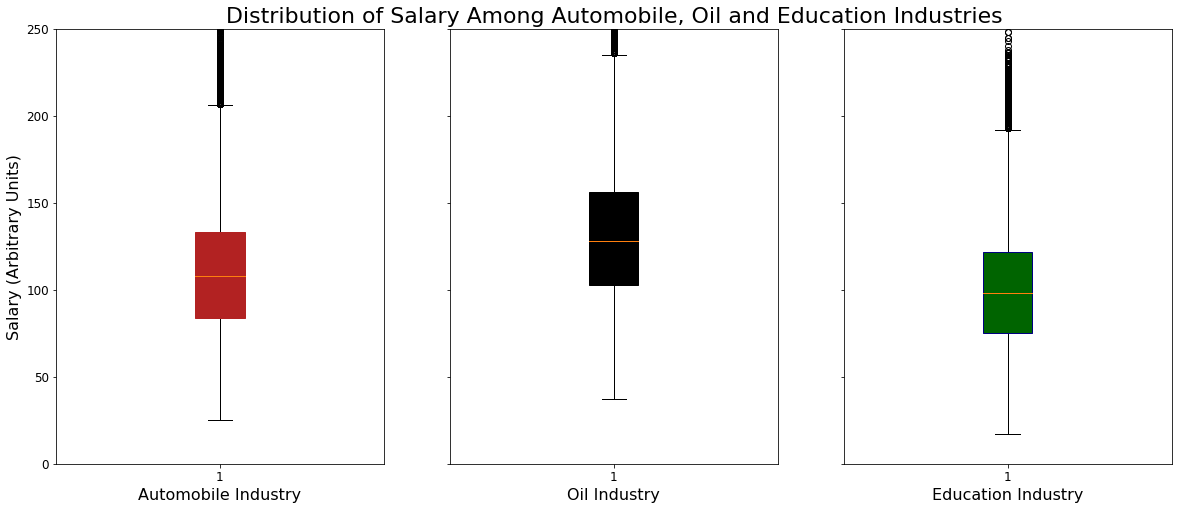

In [15]:
# create plots

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 8), sharey = True)



ax1.boxplot(auto_salary_df['salary'], patch_artist = True,
            boxprops=dict(facecolor= 'firebrick', color='firebrick'))

ax1.set_xlabel('Automobile Industry', fontsize = 16)
ax1.set_ylabel('Salary (Arbitrary Units)', fontsize = 16)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax1.set_ylim(0, 250)


ax2.boxplot(oil_salary_df['salary'], patch_artist = True,
            boxprops = dict(facecolor = 'black', color = 'black'))

ax2.set_xlabel('Oil Industry', fontsize = 16)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)


ax3.boxplot(education_salary_df['salary'], patch_artist = True,
            boxprops = dict(facecolor = 'darkgreen', color = 'navy'))

ax3.set_xlabel('Education Industry', fontsize = 16)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 12)


ax2.set_title('Distribution of Salary Among Automobile, Oil and Education Industries', fontsize = 22)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)

**Interpretation**

There are noticeable but small differences among the 3 chosen industry in terms of salary distribution. 

- The highest-paying job postings in the Oil industry earn the most compared to their counterparts in the other two industries. The same can be said for the lowest-paying roles


- The middle 50% of job postings in Oil also pay more than the middle 50% in the Automobile and Education industries


- The salaries offered for jobs in the Automobile industry seem to lie in the middle of the other two industries

This visualisation suggests there may be a link between the type of industry one is in and the salary offered by the job. As a result, the type of industry may have some predictive power in computing new salaries.

---
What about mean salary per industry?

In [16]:
industry_salary_df = data_combined.groupby('industry').mean().reset_index()

Text(0.5,0,'Industry')

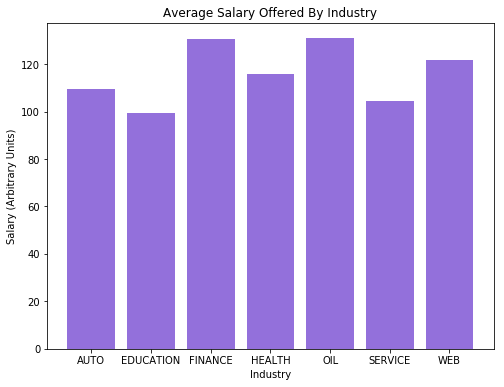

In [17]:
plt.figure(figsize = (8, 6))
plt.bar(industry_salary_df['industry'], industry_salary_df['salary'], color = 'mediumpurple')
plt.title('Average Salary Offered By Industry')
plt.ylabel('Salary (Arbitrary Units)')
plt.xlabel('Industry')

**Interpretation**

Lorem Ipsum

----

Next, I would like to find out the relationship between salary offered, the distance of the job from Metropolis and the degree required for the job.

For the types of degrees, I will choose the postings where the' requirement is Doctoral, Bachelor's or no degree so that the plot is not overloaded with points. For the same reason, I will take a random 10,000-instance sample from the data

Text(0,0.5,'Salary (Arbitrary Units)')

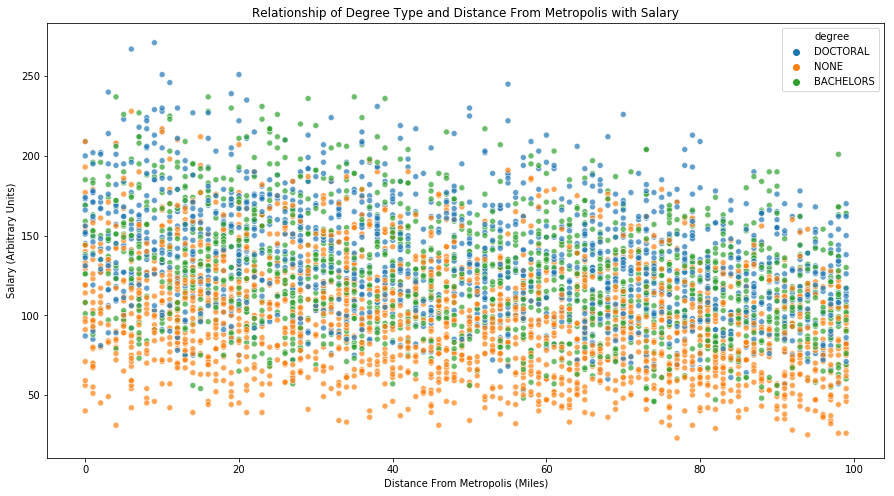

In [18]:
# create dataframe with only Doctoral, Bachelor and None degree values

three_degree_df = data_combined.loc[(data_combined['degree'] == 'DOCTORAL') |
                                   (data_combined['degree'] == 'BACHELORS') |
                                   (data_combined['degree'] == 'NONE')]


# take a 10,000 instance random sample

sample_three_degree_df = three_degree_df.sample(n=5000, random_state=42, axis=0)


# plot

plt.figure(figsize = (15, 8))

sns.scatterplot(sample_three_degree_df['milesFromMetropolis'],
               sample_three_degree_df['salary'],
               hue = sample_three_degree_df['degree'],
               alpha = 0.7,
               cmap = 'Set2')

plt.title('Relationship of Degree Type and Distance From Metropolis with Salary')
plt.xlabel('Distance From Metropolis (Miles)')
plt.ylabel('Salary (Arbitrary Units)')

- There seems to be no meaningful relationship between the distance that a job is from Metropolis and the salary offered. One could expect that jobs closer to urbans areas such as cities would pay noticeably more, but the data does not seem to support this notion


- Postings that require no degree have salaries concentrated in the bottom half of the plot. This suggests such job types pay less than other jobs that require degrees for the most part


- There seems to be no meaningful difference in salary offered by jobs that require a Doctoral degree versus those that require a Bachelor's degree. This is somewhat surprising, as jobs that require more advanced skills (for which a Doctoral degree can serve as evidence) are usually thought to be higher paying



In [19]:


data_combined.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [20]:
data_combined.groupby('jobType')['salary'].mean()

jobType
CEO               145.311425
CFO               135.458547
CTO               135.481067
JANITOR            70.813045
JUNIOR             95.333087
MANAGER           115.368518
SENIOR            105.487775
VICE_PRESIDENT    125.368630
Name: salary, dtype: float64

In [21]:
jobType_df = data_combined.loc[:, ['jobType', 'salary']]

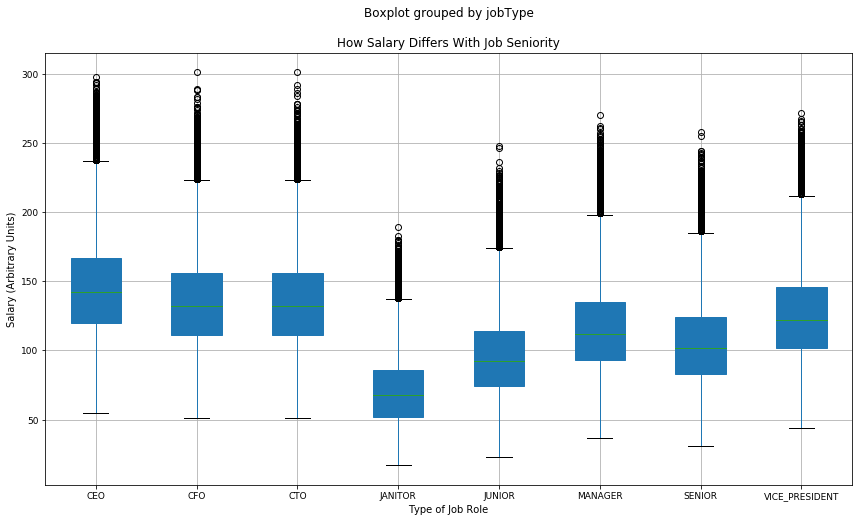

In [22]:
jobType_df.boxplot(by="jobType",
                   column="salary", 
                   patch_artist = True,
                   showfliers = True, 
                   figsize = (14, 8))

plt.title('How Salary Differs With Job Seniority')
plt.ylabel('Salary (Arbitrary Units)')
plt.xlabel('Type of Job Role')
plt.tick_params(axis = 'both', which = 'major', labelsize = 9)
plt.show()

**Correlations between integer variables**

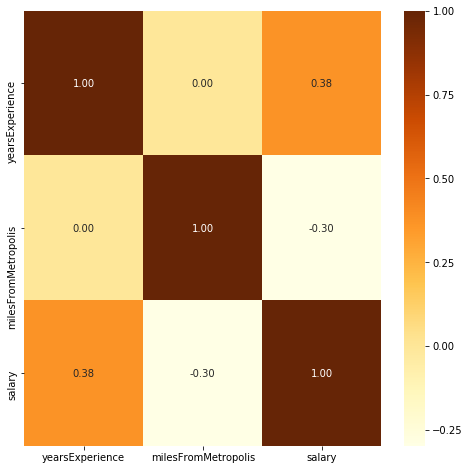

In [23]:
fig, axes = plt.subplots(1, 1, figsize = (8, 8))
sns.heatmap(data_combined.corr(), annot = True, fmt = '.2f', cmap = 'YlOrBr')

### ---- 5 Establish a baseline ----

In [24]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

For a baseline model, I will use the average salary per industry as the prediction. 

I will then calculate RMSE to find a benchmark to improve upon.

In [25]:
industry_salary_mean = data_combined.groupby('industry')['salary'].mean()

In [26]:
industry_salary_mean

industry
AUTO         109.435222
EDUCATION     99.448386
FINANCE      130.747659
HEALTH       115.735540
OIL          130.953863
SERVICE      104.446820
WEB          121.645362
Name: salary, dtype: float64

In [27]:
# initialise variables

auto_salary = industry_salary_mean[0]
education_salary = industry_salary_mean[1]
finance_salary = industry_salary_mean[2]
health_salary = industry_salary_mean[3]
oil_salary = industry_salary_mean[4]
service_salary = industry_salary_mean[5]
web_salary = industry_salary_mean[6]

In [28]:
# create new Baseline Prediction column and fill with NaNs, to be replaced shortly

data_combined['Baseline Prediction'] = np.nan

In [29]:
# replace each NaN with the average salary of the industry for the relevant row

data_combined['Baseline Prediction'] = np.where(
                                      (data_combined['industry'] == 'AUTO'), 
                                       auto_salary, data_combined['Baseline Prediction'])

data_combined['Baseline Prediction'] = np.where(
                                      (data_combined['industry'] == 'EDUCATION'), 
                                       education_salary, data_combined['Baseline Prediction'])

data_combined['Baseline Prediction'] = np.where(
                                      (data_combined['industry'] == 'FINANCE'), 
                                       finance_salary, data_combined['Baseline Prediction'])

data_combined['Baseline Prediction'] = np.where(
                                      (data_combined['industry'] == 'HEALTH'), 
                                       health_salary, data_combined['Baseline Prediction'])

data_combined['Baseline Prediction'] = np.where(
                                      (data_combined['industry'] == 'OIL'), 
                                       oil_salary, data_combined['Baseline Prediction'])

data_combined['Baseline Prediction'] = np.where(
                                      (data_combined['industry'] == 'SERVICE'), 
                                       service_salary, data_combined['Baseline Prediction'])

data_combined['Baseline Prediction'] = np.where(
                                      (data_combined['industry'] == 'WEB'), 
                                       web_salary, data_combined['Baseline Prediction'])

In [30]:
data_combined

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,Baseline Prediction
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,115.735540
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,121.645362
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,115.735540
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,109.435222
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,130.747659
...,...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88,115.735540
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160,130.747659
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64,99.448386
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149,115.735540


In [31]:
# separate features, output and baseline predictions from one another

X_train = data_combined[['jobId', 'companyId', 'jobType', 
                 'degree', 'major', 'industry',
                 'yearsExperience', 'milesFromMetropolis']]

y_train = data_combined['salary']

y_predicted = data_combined['Baseline Prediction']

In [32]:
# calculate RMSE

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_train, y_predicted))

print('The baseline model RMSE is {}'.format(rmse))

The baseline model RMSE is 36.974625769373986


For referencial purposes, I will also calculate MSE:

In [33]:
mse = rmse**2
print('The baseline model MSE is {}'.format(mse))

The baseline model MSE is 1367.122950785255


**Questions to investigate for myself:**

1. Find out if I need to scale data. From a cursory reading of notes, scaling is needed when features have different scales. This does not seem to be the case for my data, but I will have to make sure


- *from the first graph in our EDA, we see that our two main interval features have some difference in scale. I can run a model without scaling and with scaling to see if the latter introduces any improvement in MSE*


2. Find out what ML models to use and justify them. For this I'll need to re-read notes which will take a while


3. Investigate whether feature engineering should be pursued. Google what sort of features I can engineer then add them to dataset


- *Can and should decompose categorical features (by creating dummy variables? Refer to notes)*


- *A simple addition would be the average salary for each ordinal variable. So average salary for the relevant **major**, **degree**, **job type** and so on*

### ---- 6 Hypothesize solution ----

In [34]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [35]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### Convert categorical features to numerical features: 'degree'

The first priority we have in terms of feature engineering is to decompose our categorical variables into numerical variables. Let us first do this with the 'degree' column type.

'Degree' can be considered a ordinal variable (the order of the data matters) more so than a nominal one (the order does not matter); clearly, a Doctoral degree is more advanced than a Master's degree, which itself is more advanced than a Bachelor's degree

As a result, it would seem the best way to convert this categorical feature into numbers is to manually encode them, where 0 may correspond to 'NONE' (no degree), 1 to 'HIGH_SCHOOl', 2 to 'BACHELORS' and so on.

We could use Label Encoding, but this option does not guarantee the order we want. For example, 'HIGH_SCHOOL' may be assigned to '3' (undesirable) and not '0' (desirable)

In [36]:
data_combined.degree.value_counts()

HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64

In [37]:
data_combined['Degree Category'] = data_combined['degree']

In [38]:
data_combined

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,Baseline Prediction,Degree Category
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,115.735540,MASTERS
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,121.645362,HIGH_SCHOOL
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,115.735540,DOCTORAL
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,109.435222,DOCTORAL
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,130.747659,BACHELORS
...,...,...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88,115.735540,BACHELORS
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160,130.747659,HIGH_SCHOOL
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64,99.448386,HIGH_SCHOOL
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149,115.735540,MASTERS


In [39]:
data_combined = data_combined.replace({'Degree Category':
                                       {'NONE':0, 'HIGH_SCHOOL':1, 
                                        'BACHELORS':2, 'MASTERS':3,
                                        'DOCTORAL':4}})

In [40]:
data_combined

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,Baseline Prediction,Degree Category
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,115.735540,3
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,121.645362,1
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,115.735540,4
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,109.435222,4
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,130.747659,2
...,...,...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88,115.735540,2
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160,130.747659,1
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64,99.448386,1
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149,115.735540,3


### Convert categorical features to numerical features: 'jobType'


Similar to 'degree', 'jobType' can also be considered an ordinal variable, not a nominal one, because a CEO role has the highest possible seniority, followed by a CFO role and so on until a janitor role\*



Morover, I chose to use manual encoding over one-hot encoding for this feature for an additional reason; there are 8 values in this categorical feature. One Hot Encoding would create 8 more columns, all of which would be sparse. This would not be a good use of memory and may slow down our model training

There, we perform the same transformation here as we did above

\**There is some ambiguity regarding which of CFO or CTO is the more senior rank as this often depends on company context; I will simply consider CFO to be the more senior rank since this has historically been the case*

In [41]:
data_combined.jobType.value_counts()

SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64

In [42]:
data_combined['Job Type Category'] = data_combined['jobType']

data_combined = data_combined.replace({'Job Type Category':
                                       {'JANITOR':0, 'JUNIOR':1, 
                                        'SENIOR':2, 'MANAGER':3,
                                        'VICE_PRESIDENT':4, 'CTO':5,
                                        'CFO':6, 'CEO':7}})

In [43]:
data_combined

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,Baseline Prediction,Degree Category,Job Type Category
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,115.735540,3,6
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,121.645362,1,7
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,115.735540,4,4
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,109.435222,4,3
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,130.747659,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88,115.735540,2,4
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160,130.747659,1,5
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64,99.448386,1,1
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149,115.735540,3,6


### Convert categorical features to numerical features: 'major'

Unlike 'degree' and 'jobType', 'major' cannot be considered to be an ordinal variable. 'Physics' cannot be said to be greater or lesser in some intuitive way than 'Engineering'. As a result, manual label encoding that maps options to different numbers (1, 2, 3...) is not the optimal approach here


Hence, it would be better to use dummy variables. One disadvantage of this, as referred to before, is that this will add many sparse columns to our dataframe. This may slow down our model training

In [44]:
major_dummy_data = pd.get_dummies(data_combined['major'])
major_dummy_data = major_dummy_data.rename({'BIOLOGY':'Major_Biology',
                                            'BUSINESS':'Major_Business',
                                            'CHEMISTRY':'Major_Chemistry',
                                            'COMPSCI':'Major_CompSci',
                                            'ENGINEERING':'Major_Engineering',
                                            'LITERATURE':'Major_Literature',
                                            'MATH':'Major_Math',
                                            'NONE':'Major_None',
                                            'PHYSICS':'Major_Physics'},
                                             axis = 1)

major_dummy_data.head()

,Major_Biology,Major_Business,Major_Chemistry,Major_CompSci,Major_Engineering,Major_Literature,Major_Math,Major_None,Major_Physics
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [45]:
data_combined = pd.concat([data_combined, major_dummy_data], axis = 1)

### Convert categorical features to numerical features: 'industry'

Similar to the 'major' variable, 'industry' is also nominal; we cannot intuitively order its values. Again, we will create dummy variables

In [46]:
industry_dummy_data = pd.get_dummies(data_combined['industry'])

industry_dummy_data = industry_dummy_data.rename({'AUTO':'Industry_Auto',
                                            'EDUCATION':'Industry_Education',
                                            'FINANCE':'Industry_Finance',
                                            'HEALTH':'Industry_Health',
                                            'OIL':'Industry_Oil',
                                            'SERVICE':'Industry_Service',
                                            'WEB':'Industry_Web'},
                                             axis = 1)



industry_dummy_data.head()

,Industry_Auto,Industry_Education,Industry_Finance,Industry_Health,Industry_Oil,Industry_Service,Industry_Web
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0


In [47]:
data_combined = pd.concat([data_combined, industry_dummy_data], axis = 1)

In [48]:
data_combined.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,Baseline Prediction,...,Major_Math,Major_None,Major_Physics,Industry_Auto,Industry_Education,Industry_Finance,Industry_Health,Industry_Oil,Industry_Service,Industry_Web
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88,115.735540,...,0,0,0,0,0,0,1,0,0,0
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160,130.747659,...,0,1,0,0,0,1,0,0,0,0
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64,99.448386,...,0,1,0,0,1,0,0,0,0,0
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149,115.735540,...,0,1,0,0,0,0,1,0,0,0
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88,99.448386,...,0,1,0,0,1,0,0,0,0,0


In [145]:
data_combined

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,Baseline Prediction,...,Major_Physics,Industry_Auto,Industry_Education,Industry_Finance,Industry_Health,Industry_Oil,Industry_Service,Industry_Web,Mean Salary Per Job Type,Mean Salary Per Major
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,115.735540,...,0,0,0,0,1,0,0,0,135.458547,133.322042
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,121.645362,...,0,0,0,0,0,0,0,1,145.311425,102.583864
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,115.735540,...,1,0,0,0,1,0,0,0,125.368630,102.583864
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,109.435222,...,0,1,0,0,0,0,0,0,115.368518,129.072085
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,130.747659,...,1,0,0,1,0,0,0,0,125.368630,102.583864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88,115.735540,...,0,0,0,0,1,0,0,0,125.368630,129.072085
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160,130.747659,...,0,0,0,1,0,0,0,0,135.481067,102.583864
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64,99.448386,...,0,0,1,0,0,0,0,0,95.333087,102.583864
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149,115.735540,...,0,0,0,0,1,0,0,0,135.458547,102.583864


## More feature engineering approaches

- cap outliers


- feature scaling

#### Mean salary for each job type

In [119]:
job_mean_salary = data_combined.groupby('jobType')['salary'].mean()

job_mean_salary

# intialise variables

ceo_salary = job_mean_salary[0]
cfo_salary = job_mean_salary[1]
cto_salary = job_mean_salary[2]
janitor_salary = job_mean_salary[3]
junior_salary = job_mean_salary[4]
manager_salary = job_mean_salary[5]
senior_salary = job_mean_salary[6]
vp_salary = job_mean_salary[7]


jobType
CEO               145.311425
CFO               135.458547
CTO               135.481067
JANITOR            70.813045
JUNIOR             95.333087
MANAGER           115.368518
SENIOR            105.487775
VICE_PRESIDENT    125.368630
Name: salary, dtype: float64

In [122]:
data_combined['Mean Salary Per Job Type'] = np.NaN

In [123]:
# replace each NaN with the average salary of the industry for the relevant row

data_combined['Mean Salary Per Job Type'] = np.where(
                                      (data_combined['jobType'] == 'CEO'), 
                                       ceo_salary, data_combined['Mean Salary Per Job Type'])

data_combined['Mean Salary Per Job Type'] = np.where(
                                      (data_combined['jobType'] == 'CFO'), 
                                       cfo_salary, data_combined['Mean Salary Per Job Type'])

data_combined['Mean Salary Per Job Type'] = np.where(
                                      (data_combined['jobType'] == 'CTO'), 
                                       cto_salary, data_combined['Mean Salary Per Job Type'])

data_combined['Mean Salary Per Job Type'] = np.where(
                                      (data_combined['jobType'] == 'JANITOR'), 
                                       janitor_salary, data_combined['Mean Salary Per Job Type'])

data_combined['Mean Salary Per Job Type'] = np.where(
                                      (data_combined['jobType'] == 'JUNIOR'), 
                                       junior_salary, data_combined['Mean Salary Per Job Type'])

data_combined['Mean Salary Per Job Type'] = np.where(
                                      (data_combined['jobType'] == 'MANAGER'), 
                                       manager_salary, data_combined['Mean Salary Per Job Type'])

data_combined['Mean Salary Per Job Type'] = np.where(
                                      (data_combined['jobType'] == 'SENIOR'), 
                                       senior_salary, data_combined['Mean Salary Per Job Type'])

data_combined['Mean Salary Per Job Type'] = np.where(
                                      (data_combined['jobType'] == 'VICE_PRESIDENT'), 
                                       vp_salary, data_combined['Mean Salary Per Job Type'])

### ---- 8 Create models ----

In [50]:
data_combined.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary',
       'Baseline Prediction', 'Degree Category', 'Job Type Category',
       'Major_Biology', 'Major_Business', 'Major_Chemistry', 'Major_CompSci',
       'Major_Engineering', 'Major_Literature', 'Major_Math', 'Major_None',
       'Major_Physics', 'Industry_Auto', 'Industry_Education',
       'Industry_Finance', 'Industry_Health', 'Industry_Oil',
       'Industry_Service', 'Industry_Web'],
      dtype='object')

In [137]:
# repeat step of separating features, output and 
# baseline predictions from one another to include
# newly created features

X_train = data_combined
X_train = X_train.drop(['salary', 'jobId', 'companyId', 
                        'jobType', 'degree', 'major', 
                        'industry'], axis = 1)

y_train = data_combined['salary']

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### Linear Regression

In [138]:
#create and tune the models that you brainstormed during part 2

from sklearn import linear_model

lr = linear_model.LinearRegression()


In [139]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 4)

# to get RMSE in case of regression

model_rmse_scores = np.sqrt(-scores)

scores.mean()

-386.64140566584564

### Standard Scaler applied to all features in X_train: linear SVC

In [140]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)

In [141]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon = 0.1)

scores = cross_val_score(svm_reg, X_train_scaled, y_train, scoring = 'neg_mean_squared_error', cv = 4)

# to get RMSE in case of regression

model_rmse_scores = np.sqrt(-scores)

scores.mean()

-387.8726422868304

### Removing outliers

#### Grid search with Random Forests

In [ ]:
# for grid search, get 10% samples of X_train and y_train

ten_percent_data = data_combined.sample(frac = 0.1, random_state = 42)

X_train_sample = ten_percent_data
X_train_sample = X_train_sample.drop(['salary', 'jobId', 'companyId', 
                        'jobType', 'degree', 'major', 
                        'industry'], axis = 1)

y_train_sample = ten_percent_data['salary']

from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

rf_reg.get_params()

#scores = cross_val_score(tree_reg, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 4)

# import
from sklearn.model_selection import GridSearchCV

# initialise parameters
param_grid = [ {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10], 'bootstrap': [False]} ]

# initialise ML model
forest_reg = RandomForestRegressor()

# initialise Grid Search
Grid1 = GridSearchCV(forest_reg, param_grid, cv = 3, scoring = 'neg_mean_squared_error')

# fit
Grid1.fit(X_train_sample, y_train_sample)

# find best parameters
Grid1.best_estimator_

#find scores
scores = Grid1.cv_results_
scores['mean_test_score']

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data